# Wstęp
Stworzone są nastepujące wykresy:
- Rozkład głównych emocji
- Rozkład podrzędnych emocji
- Rozkład par emocji (głowna, podrzędna)


In [56]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

sns.set_theme(style='darkgrid')

con = sqlite3.connect("game_database.db")
cur = con.cursor()

In [37]:
sql_query = '''SELECT * FROM PlayerEmotions pe
                LEFT JOIN difficulties d ON (pe.game_id = d.game_id) AND (pe.game_id NOT IN (SELECT d2.game_id FROM difficulties d2 GROUP BY d2.game_id HAVING COUNT(*) > 1))
                LEFT JOIN game g ON pe.game_id = g.game_id
                -- WHERE g.playing_time >= 10;'''

df = pd.read_sql_query(sql_query, con)

# change values between columns player_z and face_confidence;
df['player_z'], df['face_confidence'] = df['face_confidence'], df['player_z']

# filter out the rows where the face_confidence is less than 0.9
df = df[df['face_confidence'] >= 0.9]
df.loc[df['second_emotion_value'] < 0.1, 'second_emotion'] = "none"
print(df.head())

   game_id first_emotion  first_emotion_value second_emotion  \
0       58       neutral            99.998924           none   
1       58       neutral            99.609207          happy   
2       58       neutral            99.156670          happy   
3       58       neutral            99.975517           none   
4       58       neutral            99.989166           none   

   second_emotion_value  player_z  face_confidence  game_id  difficulty_level  \
0              0.000759       1.0       357.646729     58.0               2.0   
1              0.351305       1.0       770.153137     58.0               2.0   
2              0.825660       1.0      1182.530762     58.0               2.0   
3              0.021916       1.0      1585.970825     58.0               2.0   
4              0.009491       1.0      1993.787720     58.0               2.0   

   game_id  score  player_satisfaction  playing_time  
0       58   2699                   -1      9.776133  
1       58   2699 

# Plotting

## Rozkłady zmiennych

c:\Anaconda\lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


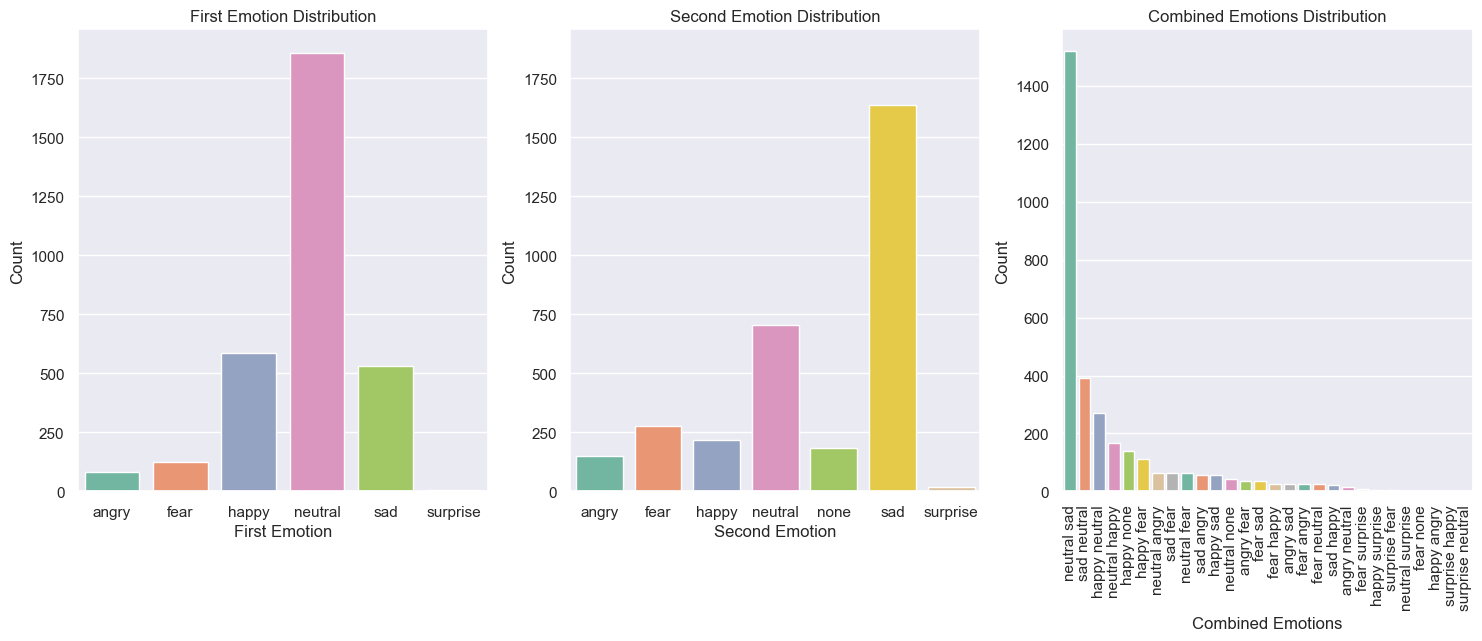

In [38]:
# Plot first_emotion and second_emotion distribution
df_plot = df.copy()
max_emotions_count = df_plot[['first_emotion', 'second_emotion']].apply(pd.Series.value_counts).max().max() + 100

# change emotions to categorical values
df_plot['combined_emotions'] = df_plot['first_emotion'] + ' ' + df_plot['second_emotion']

df_plot['first_emotion'] = df_plot['first_emotion'].astype('category')
df_plot['second_emotion'] = df_plot['second_emotion'].astype('category')

# Change second emotion to None if second_emotion_value is lower than 0.1


fig, ax = plt.subplots(1, 3, figsize=(18, 6))
sns.countplot(x='first_emotion', data=df_plot, palette='Set2', ax=ax[0])
ax[0].set_title('First Emotion Distribution')
ax[0].set_xlabel('First Emotion')
ax[0].set_ylabel('Count')
ax[0].set_ylim(0, max_emotions_count)

sns.countplot(x='second_emotion', data=df_plot, palette='Set2', ax=ax[1])
ax[1].set_title('Second Emotion Distribution')
ax[1].set_xlabel('Second Emotion')
ax[1].set_ylabel('Count')
ax[1].set_ylim(0, max_emotions_count)

# plot the count plot of combined emotions
sns.countplot(x='combined_emotions', data=df_plot, palette='Set2', ax=ax[2], order=df_plot['combined_emotions'].value_counts().index)
ax[2].set_xlabel('Combined Emotions')
ax[2].set_ylabel('Count')
ax[2].set_xticklabels(ax[2].get_xticklabels(), rotation=90)
ax[2].set_title('Combined Emotions Distribution')

plt.show()

## Difficulty and Emotions

In [39]:
df_plot = df_plot.dropna(subset=['difficulty_level'])
print(df_plot[df_plot['difficulty_level'].isnull()])

Empty DataFrame
Columns: [game_id, first_emotion, first_emotion_value, second_emotion, second_emotion_value, player_z, face_confidence, game_id, difficulty_level, game_id, score, player_satisfaction, playing_time, combined_emotions]
Index: []


c:\Anaconda\lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


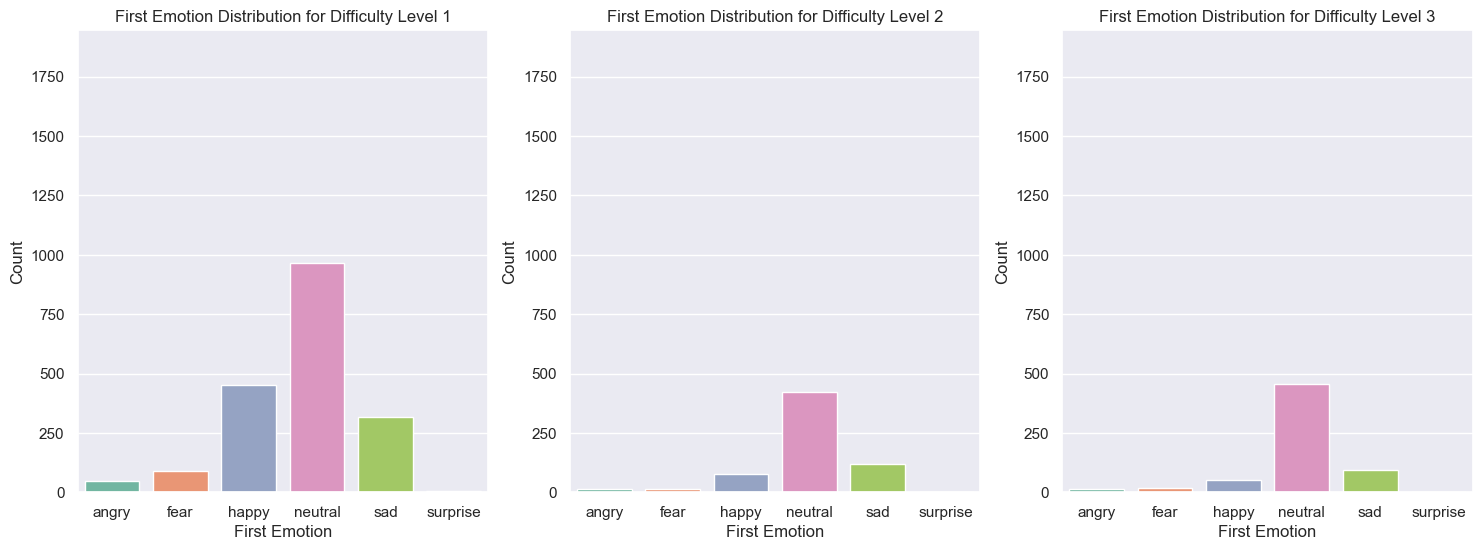

In [40]:
df_plot = df.copy()
df_plot = df_plot.dropna(subset=['difficulty_level'])
max_emotions_count = df_plot[['first_emotion', 'second_emotion']].apply(pd.Series.value_counts).max().max() + 100

# change emotions to categorical values
df_plot['combined_emotions'] = df_plot['first_emotion'] + ' ' + df_plot['second_emotion']

df_plot['first_emotion'] = df_plot['first_emotion'].astype('category')
df_plot['second_emotion'] = df_plot['second_emotion'].astype('category')

fig, ax = plt.subplots(1, 3, figsize=(18, 6))
for difficulty in df_plot['difficulty_level'].unique():
    i = int(difficulty) - 1
    df_plot_difficulty = df_plot[df_plot['difficulty_level'] == difficulty]
    sns.countplot(x='first_emotion', data=df_plot_difficulty, palette='Set2', ax=ax[i], label=difficulty)
    ax[i].set_title('First Emotion Distribution for Difficulty Level ' + str(i+1))
    ax[i].set_xlabel('First Emotion')
    ax[i].set_ylabel('Count')
    ax[i].set_ylim(0, max_emotions_count)


## Satisfaction vs emotions

c:\Anaconda\lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


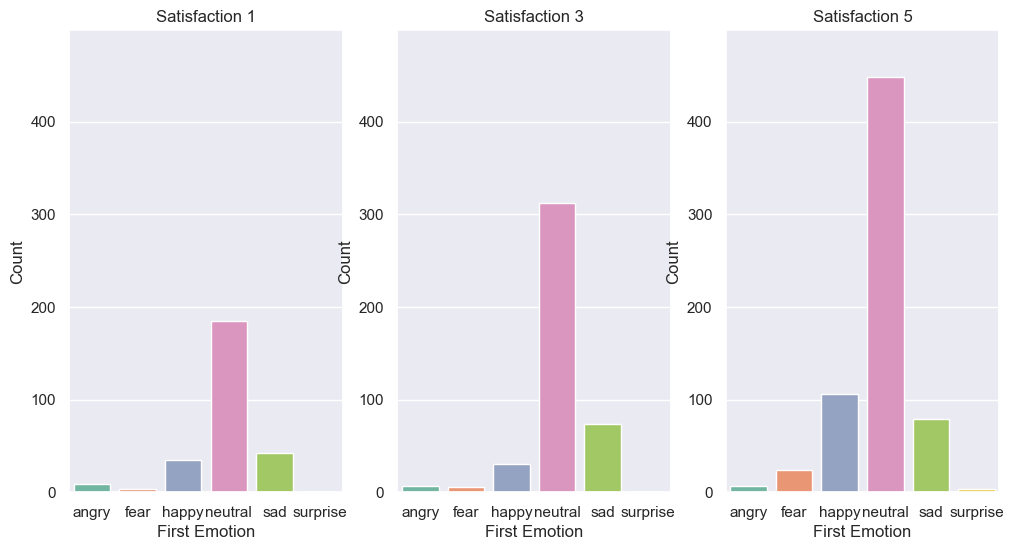

In [47]:
df_plot = df.copy()

# filter out games with time > 120 sec
df_plot = df_plot[df_plot['playing_time'] <= 120]

# create new column for player satisfaction that combines satisfaction level 1 with 2 and 4 with 5
df_plot['player_satisfaction_combined'] = df_plot['player_satisfaction'].replace({1: 1, 2: 1, 3: 3, 4: 5, 5: 5})
df_plot = df_plot[df_plot['player_satisfaction_combined'] !=-1]

# group by combined satiscation level and first emotion and find the max count
max_count = df_plot.copy().groupby(['player_satisfaction_combined', 'first_emotion']).size().reset_index(name='count')['count'].max() +50

# first emotion as categorical
df_plot['first_emotion'] = df_plot['first_emotion'].astype('category')

fig, ax = plt.subplots(1, 3, figsize=(12, 6))
for i, satisfaction in enumerate(sorted(df_plot['player_satisfaction_combined'].unique())):
    df_plot_satisfaction = df_plot[df_plot['player_satisfaction_combined'] == satisfaction]
    sns.countplot(x='first_emotion', data=df_plot_satisfaction, palette='Set2', ax=ax[i], label=satisfaction)
    ax[i].set_title('Satisfaction ' + str(satisfaction))
    ax[i].set_xlabel('First Emotion')
    ax[i].set_ylabel('Count')
    ax[i].set_ylim(0, max_count)

In [57]:
# create data frame that contains count of first emotion for each satisfaction level
df_plot_count = df_plot.copy().groupby(['player_satisfaction_combined', 'first_emotion']).size().reset_index(name='count')

# create percentages of count of first emotion for each satisfaction level
df_2 = df_plot_count.groupby('player_satisfaction_combined')['count'].sum()

df_merged = pd.merge(df_plot_count, df_2, on='player_satisfaction_combined', suffixes=('', '_total'))
df_merged['percentage'] = df_merged['count'] / df_merged['count_total'] * 100
df_merged = df_merged.drop(columns=['count', 'count_total'])
print(df_merged)

# save the merged data frame to csv if it is not present at path
if not os.path.exists('first_emotion_percentage-satisfaction.csv'):
    df_merged.to_csv('first_emotion_percentage-satisfaction.csv', index=False)

    player_satisfaction_combined first_emotion  percentage
0                              1         angry    3.284672
1                              1          fear    1.094891
2                              1         happy   12.773723
3                              1       neutral   67.518248
4                              1           sad   15.328467
5                              1      surprise    0.000000
6                              3         angry    1.627907
7                              3          fear    1.395349
8                              3         happy    7.209302
9                              3       neutral   72.558140
10                             3           sad   17.209302
11                             3      surprise    0.000000
12                             5         angry    1.047904
13                             5          fear    3.592814
14                             5         happy   15.868263
15                             5       neutral   67.2155

C:\Users\Łukasz\AppData\Local\Temp\ipykernel_10688\3454472266.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_plot_count = df_plot.copy().groupby(['player_satisfaction_combined', 'first_emotion']).size().reset_index(name='count')


In [61]:
emotion_distribution_1 = df_merged[df_merged['player_satisfaction_combined'] == 1].set_index('first_emotion')['percentage']

# change to dictionary
emotion_distribution_1 = emotion_distribution_1.to_dict()

print(emotion_distribution_1)

{'angry': 3.2846715328467155, 'fear': 1.094890510948905, 'happy': 12.773722627737227, 'neutral': 67.51824817518248, 'sad': 15.328467153284672, 'surprise': 0.0}


: 

c:\Anaconda\lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


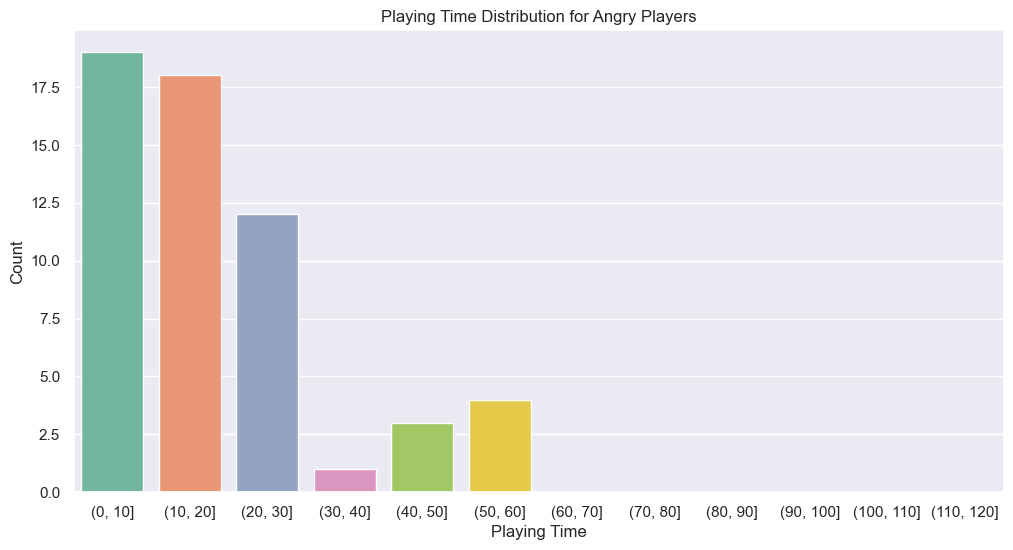

In [43]:
# check at which playing_time did player got angry
df_plot = df.copy()
df_plot = df_plot[df_plot['first_emotion'] == 'angry']
df_plot = df_plot.dropna(subset=['playing_time'])
df_plot['playing_time'] = df_plot['playing_time'].astype('int')
df_plot['playing_time'] = pd.cut(df_plot['playing_time'], bins=range(0, 121, 10))
df_plot['playing_time'] = df_plot['playing_time'].astype('category')

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
sns.countplot(x='playing_time', data=df_plot, palette='Set2', ax=ax)
ax.set_title('Playing Time Distribution for Angry Players')
ax.set_xlabel('Playing Time')
ax.set_ylabel('Count')
plt.show()


c:\Anaconda\lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


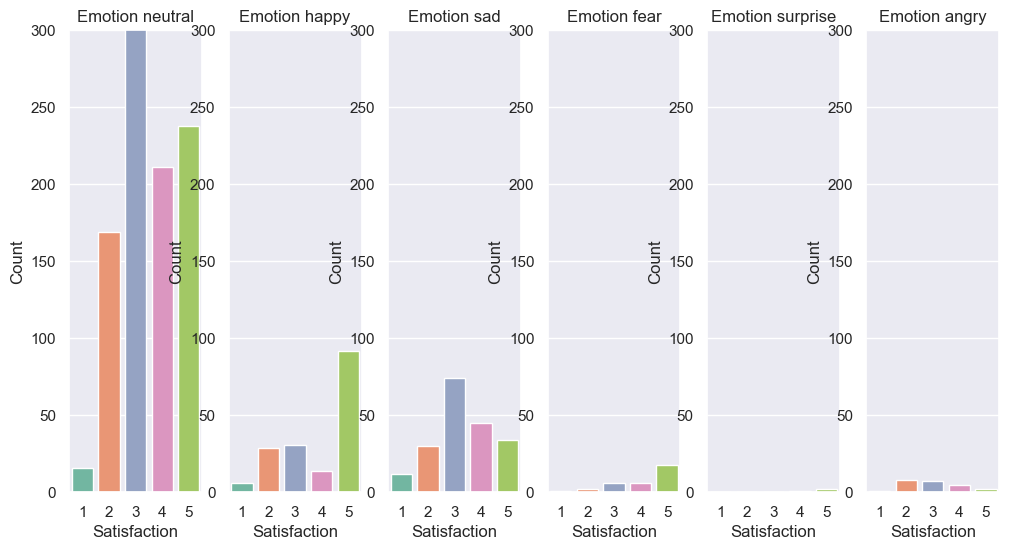

In [42]:
# plot satisfaction distribution for every emotion
df_plot = df.copy()
df_plot = df[df['playing_time'] <= 120]
df_plot = df_plot.dropna(subset=['first_emotion'])
# drop -1 values from player_satisfaction
df_plot = df_plot[df_plot['player_satisfaction'] != -1]
df_plot['first_emotion'] = df_plot['first_emotion'].astype('category')
df_plot['player_satisfaction'] = df_plot['player_satisfaction'].astype('category')

fig, ax = plt.subplots(1, 6, figsize=(12, 6))
for i, emotion in enumerate(df_plot['first_emotion'].unique()):
    df_plot_emotion = df_plot[df_plot['first_emotion'] == emotion]
    sns.countplot(x='player_satisfaction', data=df_plot_emotion, palette='Set2', ax=ax[i])
    ax[i].set_title('Emotion ' + str(emotion))
    ax[i].set_xlabel('Satisfaction')
    ax[i].set_ylabel('Count')
    ax[i].set_ylim(0, 300)

## Map and Emotions

In [10]:
sql_query = '''SELECT * FROM MapData md
JOIN Game g ON md.game_id = g.game_id
-- LEFT JOIN Obstacles o ON (o.position_z BETWEEN md.start AND md.end) AND (o.game_id = md.game_id)
LEFT JOIN difficulties d ON (md.game_id = d.game_id) AND (md.game_id NOT IN (SELECT d2.game_id FROM difficulties d2 GROUP BY d2.game_id HAVING COUNT(*) > 1))
LEFT JOIN PlayerEmotions pe ON (md.game_id = pe.game_id) AND (pe.player_z BETWEEN md.start AND md.end)
-- WHERE g.playing_time >= 10;'''
df = pd.read_sql_query(sql_query, con)
df = df.drop(columns=['game_id'])

print(df.head())
print(df.columns)

           map_type  lane_change_prob  small_obs_prob  gate_prob  \
0  FirstObstacleMap               0.3             0.3       0.05   
1  FirstObstacleMap               0.3             0.3       0.05   
2  FirstObstacleMap               0.3             0.3       0.05   
3  FirstObstacleMap               0.3             0.3       0.05   
4  FirstObstacleMap               0.3             0.3       0.05   

             color_theme  start   end  generation_dist  score  \
0  COLOR_THEME_COLORFULL    500  2750              250   2699   
1  COLOR_THEME_COLORFULL    500  2750              250   2699   
2  COLOR_THEME_COLORFULL    500  2750              250   2699   
3  COLOR_THEME_COLORFULL    500  2750              250   2699   
4  COLOR_THEME_COLORFULL    500  2750              250   2699   

   player_satisfaction  playing_time  difficulty_level first_emotion  \
0                   -1      9.776133               2.0       neutral   
1                   -1      9.776133               2.0  

c:\Anaconda\lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


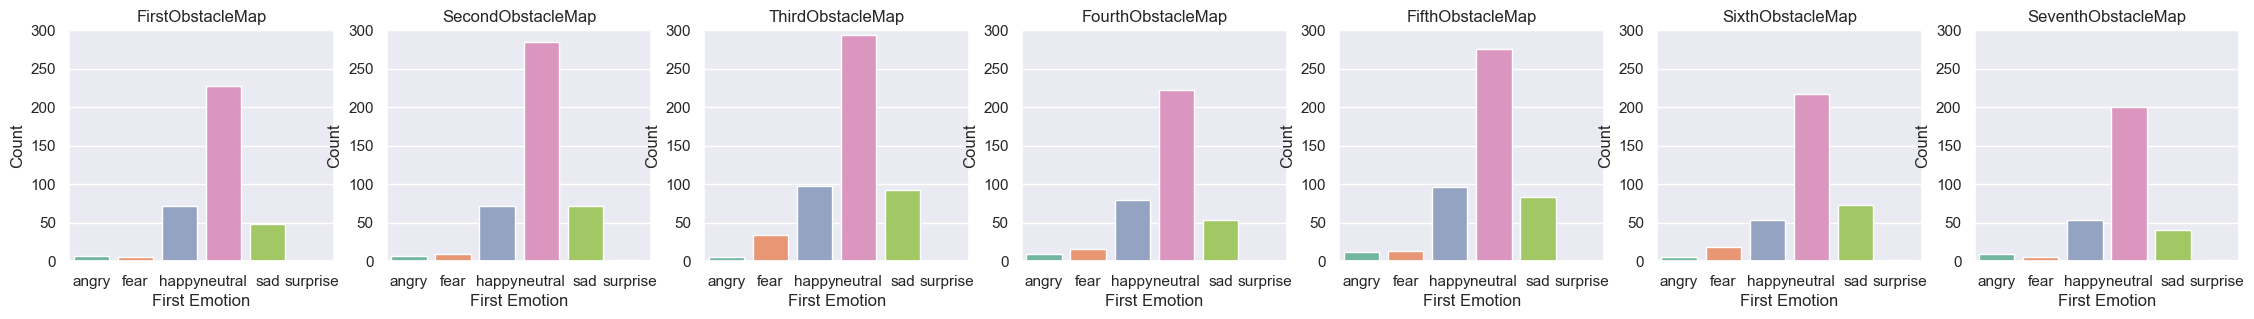

In [11]:
# create countplot for each emotion for each map_type
df_plot = df
df_plot['first_emotion'] = df_plot['first_emotion'].astype('category')
map_type = ['FirstObstacleMap', 'SecondObstacleMap', 'ThirdObstacleMap', 'FourthObstacleMap', 'FifthObstacleMap', 'SixthObstacleMap', 'SeventhObstacleMap']

fig, ax = plt.subplots(1,7, figsize=(28, 3))
for i, map_type in enumerate(map_type):
    df_map = df_plot[df_plot['map_type'] == map_type]
    sns.countplot(x='first_emotion', data=df_map, palette='Set2', ax=ax[i])
    ax[i].set_title(f'{map_type}')
    ax[i].set_xlabel('First Emotion')
    ax[i].set_ylabel('Count')
    ax[i].set_ylim(0, 300)

c:\Anaconda\lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


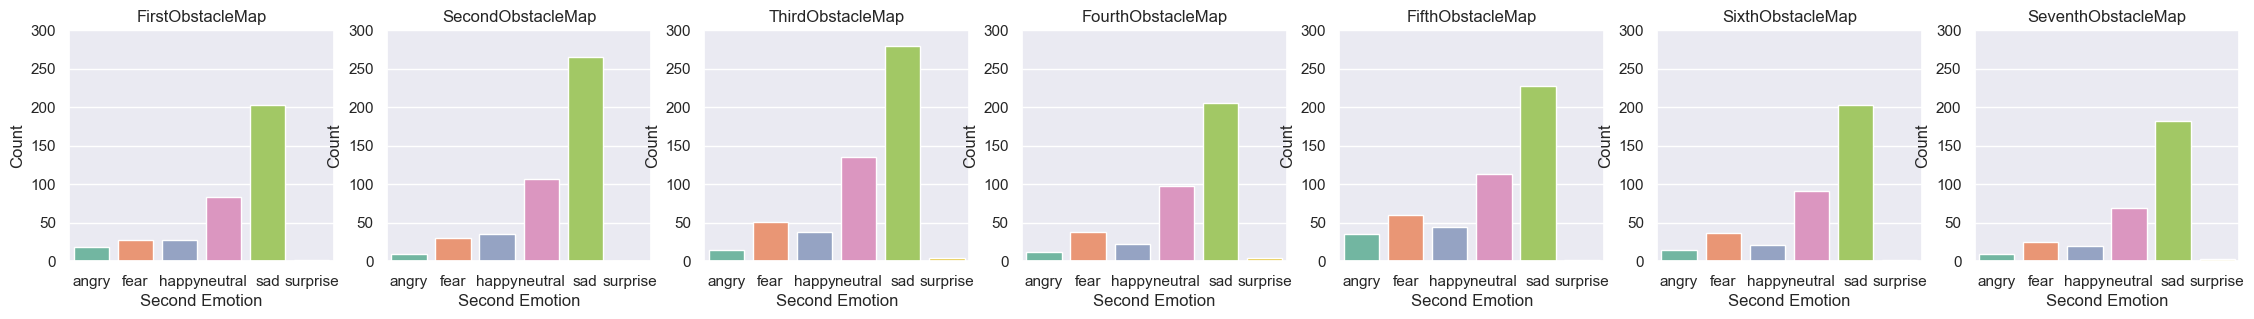

In [12]:
# create countplot for each emotion for each map_type
df_plot = df
df_plot['second_emotion'] = df_plot['second_emotion'].astype('category')
map_type = ['FirstObstacleMap', 'SecondObstacleMap', 'ThirdObstacleMap', 'FourthObstacleMap', 'FifthObstacleMap', 'SixthObstacleMap', 'SeventhObstacleMap']

fig, ax = plt.subplots(1,7, figsize=(28, 3))
for i, map_type in enumerate(map_type):
    df_map = df_plot[df_plot['map_type'] == map_type]
    sns.countplot(x='second_emotion', data=df_map, palette='Set2', ax=ax[i])
    ax[i].set_title(f'{map_type}')
    ax[i].set_xlabel('Second Emotion')
    ax[i].set_ylabel('Count')
    ax[i].set_ylim(0, 300)